Version 2024-01-17, Arvid Lundervold




[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219/blob/main/Lab2-DL/lab2-dl-simple-mnist-nn-from-scratch-numpy-no-tf-keras-but-pytorch.ipynb)


# Lab 2 Deep Learning - Simple MNIST NN from scratch (+ PyTorch)

In this notebook (modified from [Samson Zhang](https://github.com/wwsalmon): [[link](https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras/notebook)]), a simple two-layer neural network is implemented and trained on the MNIST digit 
recognizer dataset [[link](https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv)].<br> It's meant to be an instructional example, through which one can understand the underlying math of neural networks better.

( A video by Samson Zhang explaining all the math and showing the progress as he coded the network is here: https://youtu.be/w8yWXqWQYmU )

See also https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution_with_validation.ipynb from Udacity's _Deep Learning (PyTorch) [Nanodegree](https://www.udacity.com/course/deep-learning-nanodegree--nd101) program_ <br>(and these [[link1](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%201%20-%20Tensors%20in%20PyTorch%20(Solution).ipynb)]  [[link2](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%203%20-%20Training%20Neural%20Networks%20(Solution).ipynb)] for a PyTorch and Training neural networks intro).

<img src="assets/MNIST-fig.png" width=720>

## A classification task: $y \approx f(\mathbf{X}, \theta)$


where $\mathbf{X}$ is the input data, $\theta$ are the parameters of the model, and $y$ is the output.

In [1]:
# Choices for the display of locally downloaded videos or stills      
DISPLAY_VIDEO = False

In [2]:
# You might need to install the following libraries: torch 

# !pip install torch

### Check if running on Colab

In [3]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    print("Running in Google Colab.")
except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")

Not running in Google Colab.


To download the folders from GitHub while running on Google Colab, you can use the `!git clone` command in a code cell to clone the entire repository, and then use `!mv` command to move the required folders to the current directory. This code first check if the notebook is running on Colab, and if so, it clones the repository and moves (overwrites) the required folders `assets` and `data` to the current directory, and then detees the cloned repository to clean up the space.


In [4]:
if is_colab:
    # If we're in Colab, we probably need to clone the repository.
    import os
    CLONE = True    
    if os.path.exists('./assets'):
        print("./assets' exists.")
        CLONE = False
    if os.path.exists('./data'):
        print("'./data' exists.")
        CLONE = False
    if not CLONE:
        print("Nothing to do.")
    else:
        print("Cloning the ELMED219 repository...")
        !git clone https://github.com/MMIV-ML/ELMED219.git
        !mv ELMED219/Lab2-DL/assets ./
        !mv ELMED219/Lab2-DL/data ./
        !rm -rf ELMED219

### Check if GPU is available

In [5]:
# Check if GPU is available and if so, use it for PyTorch
# (This code is based on the PyTorch documentation at
# https://pytorch.org/docs/stable/notes/cuda.html)
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU for PyTorch")
    print("Device name is '{0}'.".format(torch.cuda.get_device_name(device)))  
else:
    device = torch.device("cpu")
    print("Using CPU for PyTorch")  

print(f'pytorch version: {torch.__version__}')

Using GPU for PyTorch
Device name is 'Quadro RTX 6000'.
pytorch version: 2.1.2+cu121


### Display an instructive video on "What-is-backpropagation-really-doing" (or not)

- Link (if internet access): https://youtu.be/Ilg3gGewQ5U

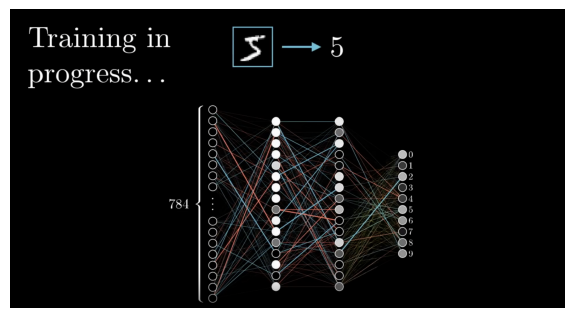

In [6]:
import os
from IPython.display import Video
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# https://www.youtube.com/watch?v=Ilg3gGewQ5U&list=PPSV 

# Create a YouTube video instance
#video = YouTubeVideo("Ilg3gGewQ5U")
# Display the video in the notebook (requires an internet connection)
#display(video)


if DISPLAY_VIDEO:
  # Path to your local video file in the assets folder
  video_path = "assets/What-is-backpropagation-really-doing.mp4"  # Downloaded from YouTube using 4K Video Downloader+.app

  # Create a Video instance and display it
  display(Video(video_path, embed=True, width=720, height=480))  # You can adjust the width and height
else:
  # Load the image
  img = mpimg.imread('assets/What-is-backpropagation-really-doing-training-in-progess.png')

  # Set the figure size to achieve a width of 720 pixels
  dpi = plt.rcParams['figure.dpi']
  fig_width = 720 / dpi

  # Create a figure with the desired size
  plt.figure(figsize=(fig_width, fig_width * (img.shape[0] / img.shape[1])))

  # Display the image
  plt.imshow(img)
  plt.axis('off')  # Turn off axis numbers and labels
  plt.show()   
  

In [7]:
file_path = 'data/train.csv'
file_size = os.path.getsize(file_path)

print(f'The size of the file "{file_path}" is {file_size} bytes ({int(file_size/(1024**2))} Mb).')
# !ls -alh data/train.csv

The size of the file "data/train.csv" is 76775041 bytes (73 Mb).


<img src="assets/MNIST-data-matrix.png" width=720>

In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Load data obtained from https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv
data = pd.read_csv('data/train.csv')
print(f'# Instances: {len(data)} ; Columns: {data.columns[0]}, {data.columns[1]}, ..., {data.columns[-1]} ; Pixel values: min={data.min().min()}, max={data.max().max()}')


# Instances: 42000 ; Columns: label, pixel0, ..., pixel783 ; Pixel values: min=0, max=255


This Python code is importing necessary libraries and loading a dataset from a CSV file. Here's a breakdown of what each line does:

1. `import numpy as np`: This line imports the numpy library, which provides support for large, multi-dimensional arrays and matrices, along with a large collection of mathematical functions to operate on these arrays.

2. `import pandas as pd`: This line imports the pandas library, which provides data structures and data analysis tools for Python.

3. `from matplotlib import pyplot as plt`: This line imports the pyplot module from the matplotlib library, which provides a MATLAB-like plotting framework.

5. `data = pd.read_csv('data/train.csv')`: This line reads the CSV file located at 'data/train.csv' into a pandas DataFrame. The DataFrame is a two-dimensional labeled data structure with columns of potentially different types. It is generally the most commonly used pandas object.

6. `print(f'Columns: {data.columns[0]}, {data.columns[1]}, ..., {data.columns[-1]} ; Pixel values: min={data.min().min()}, max={data.max().max()}')`: This line prints the first two and the last column names of the DataFrame, as well as the minimum and maximum pixel values in the DataFrame. This is useful to quickly check the structure of the DataFrame and the range of pixel values it contains.


In [9]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into test and training sets

data_test = data[0:1000].T  # 1000 instances for the test set (2.38% of total)
y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.

data_train = data[1000:m].T
y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

This Python code is part of a script for preparing a dataset for a machine learning task, specifically for training a neural network. Here's a breakdown of what each line does:

1. `data = np.array(data)`: This line converts the `data` into a numpy array. Numpy arrays are more efficient and provide more functionality for numerical operations than regular Python lists.

2. `m, n = data.shape`: This line gets the shape of the data array. `m` is the number of rows (samples) and `n` is the number of columns (features).

3. `np.random.shuffle(data)`: This line shuffles the rows of the data array. This is done to ensure that the training and test sets are random and representative of the overall distribution.

4. `data_test = data[0:1000].T`: This line selects the first 1000 samples from the shuffled data array and transposes it for the test set.

5. `y_test = data_test[0]`: This line selects the first row of the development set as the target values (`y_test`).

6. `X_test = data_test[1:n]`: This line selects the rest of the rows as the input features (`X_test`) for the test set.

7. `X_test = X_test / 255.`: This line normalizes the input features of the test set by dividing each feature by 255. This is a common practice when working with image data, which is typically represented as 8-bit integers ranging from 0 to 255.

8-12. The lines of code for `data_train`, `y_train`, and `X_train` do the same thing as the lines of code for `data_test`, `y_test`, and `X_test`, but for the training set instead of the test set.

13. `_,m_train = X_train.shape`: This line gets the shape of the training set. The underscore `_` is a common convention in Python for a variable that is being deliberately ignored. Here, it's used to ignore the number of features, since only the number of training samples `m_train` is needed.

In [10]:
print(f'X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}, m_train = {m_train}, Y_train labels: {y_train}')

X_train.shape = (784, 41000), y_train.shape = (41000,), m_train = 41000, Y_train labels: [4 9 0 ... 2 5 5]


Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

The provided mathematical framework describes the operation of a neural network (NN) with two layers, designed for image classification. Here's an explanation of each part:

### Neural Network Architecture
1. **Input Layer ($a^{[0]}$)**: Represents each pixel in a 28x28 input image, totaling 784 units. These units serve as the initial input data for the network.
2. **Hidden Layer ($a^{[1]}$)**: Consists of 10 units using the ReLU (Rectified Linear Unit) activation function. ReLU is chosen for its ability to handle non-linearity and for being computationally efficient.
3. **Output Layer ($a^{[2]}$)**: Comprises 10 units corresponding to the ten digit classes (0-9). It uses the softmax activation function, which is suitable for multi-class classification tasks.

### Forward Propagation
This process involves calculating the output from the network for a given input.
1. **Calculation of $Z^{[1]}$**: Multiplies the weights $W^{[1]}$ with the input $X$ and adds the bias $b^{[1]}$.
2. **Activation with ReLU ($A^{[1]}$)**: Applies the ReLU activation function to $Z^{[1]}$.
3. **Calculation of $Z^{[2]}$**: Similar to $Z^{[1]}$, but using the output of the first layer ($A^{[1]}$) as input.
4. **Activation with Softmax ($A^{[2]}$)**: Applies the softmax activation to $Z^{[2]}$, resulting in the final output of the network.

### Backward Propagation
This process involves adjusting the network's weights and biases based on the error in its output.
1. **Calculation of $dZ^{[2]}$**: The difference between the network's output ($A^{[2]}$) and the true labels ($Y$).
2. **Calculation of $dW^{[2]}$ and $dB^{[2]}$**: Computes the gradients of the weights and biases for the second layer.
3. **Calculation of $dZ^{[1]}$**: Calculates the gradient of the loss with respect to $Z^{[1]}$, considering the derivative of the ReLU function.
4. **Calculation of $dW^{[1]}$ and $dB^{[1]}$**: Similar to the second layer, but for the first layer.

### Parameter Updates
This step updates the weights and biases using the gradients calculated in backpropagation, scaled by a learning rate ($\alpha$).

### Variables and Shapes
- For each layer and parameter, the shape is defined to ensure proper matrix operations. For instance, $W^{[1]}$ is a 10x784 matrix, allowing it to be multiplied with the $ 784 \times m$ input $X$.

Understanding these components and their interplay is crucial for grasping how neural networks learn from data and make predictions. This network, in particular, is structured to process image data and classify it into one of several categories, a common task in machine learning.

In [11]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(y):
    one_hot_y = np.zeros((y.size, y.max() + 1))
    one_hot_y[np.arange(y.size), y] = 1
    one_hot_y = one_hot_y.T
    return one_hot_y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, y):
    one_hot_y = one_hot(y)
    dZ2 = A2 - one_hot_y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

This Python code is implementing a simple neural network from scratch using numpy. Here's a breakdown of what each function does:

1. `init_params()`: This function initializes the weights `W1` and `W2` and biases `b1` and `b2` for a two-layer neural network. The weights are initialized as random numbers between -0.5 and 0.5.

2. `ReLU(Z)`: This function applies the Rectified Linear Unit (ReLU) activation function to the input `Z`. The ReLU function returns `Z` when `Z > 0` and `0` otherwise.

3. `softmax(Z)`: This function applies the softmax activation function to the input `Z`. The softmax function is often used in the output layer of a neural network for multi-class classification problems. It transforms the input into a probability distribution over the classes.

4. `forward_prop(W1, b1, W2, b2, X)`: This function performs forward propagation through the network. It calculates the linear and activation outputs `Z1`, `A1`, `Z2`, `A2` for each layer.

5. `ReLU_deriv(Z)`: This function calculates the derivative of the ReLU function. This is used during backpropagation to calculate the gradients.

6. `one_hot(y)`: This function converts the labels `y` into a one-hot encoded format. One-hot encoding is a representation method that converts the categorical data into a format that works better with classification and regression algorithms.

7. `backward_prop(Z1, A1, Z2, A2, W1, W2, X, y)`: This function performs backward propagation through the network. It calculates the gradients of the loss function with respect to the weights and biases.

8. `update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)`: This function updates the weights and biases using the gradients calculated during backpropagation and the learning rate `alpha`.


The `backward_prop` function is implementing the backpropagation algorithm for a two-layer neural network. The backpropagation algorithm is used in training neural networks, and it involves calculating the gradient of the loss function with respect to the weights of the network.

Here's a breakdown of the function:

- `one_hot_y = one_hot(y)`: This line is converting the labels `y` into a one-hot encoded format.

- `dZ2 = A2 - one_hot_y`: This line is calculating the derivative of the loss function with respect to the pre-activation output of the second layer. This is done by subtracting the one-hot encoded true labels from the softmax outputs of the model. This suggests that the model is using the cross-entropy loss, as the derivative of the cross-entropy loss with respect to the pre-softmax activations is the difference between the model's predictions and the true labels.

- `dW2 = 1 / m * dZ2.dot(A1.T)`: This line is calculating the derivative of the loss function with respect to the weights of the second layer.

- `db2 = 1 / m * np.sum(dZ2)`: This line is calculating the derivative of the loss function with respect to the biases of the second layer.

- `dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)`: This line is calculating the derivative of the loss function with respect to the pre-activation output of the first layer.

- `dW1 = 1 / m * dZ1.dot(X.T)`: This line is calculating the derivative of the loss function with respect to the weights of the first layer.

- `db1 = 1 / m * np.sum(dZ1)`: This line is calculating the derivative of the loss function with respect to the biases of the first layer.

The function then returns the gradients `dW1`, `db1`, `dW2`, and `db2`, which can be used to update the weights and biases of the network during the gradient descent optimization process.

**Spelling these Python funtions into mathematics, using LaTeX, we have:**

1. `init_params`:

This function initializes the parameters of the simple 2-layer neural network. The parameters are matrices `W1`, `W2` and vectors `b1`, `b2`. Generally, the dimensions of these matrices and vectors depend on the dimensions of the input data and the architecture of the neural network.

   In our case, $W1$ is a matrix of shape $10 \times 784$, $b1$ is a vector of shape $10 \times 1$, $W2$ is a matrix of shape $10 \times 10$, and $b2$ is a vector of shape $10 \times 1$.<br>

   The `np.random.rand(m, n)` function in NumPy generates an array of shape $m \times n$ filled with random samples from a uniform distribution over $[0, 1)$. 

   In mathematical terms, if $X$ is a matrix generated by `np.random.rand(m, n)`, then each element $X[i, j]$ (where $0 \leq i < m$ and $0 \leq j < n$) is a random variable that follows a **uniform distribution**. This can be written as:
   $X[i, j] \sim U(0, 1)$, where $U(0, 1)$ denotes the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution) over the interval $[0, 1)$. 
   It's important to note that the elements of $X$ are _independently and identically distributed_ (**i.i.d.**), which means that the value of any particular element does not affect the values of the other elements, and all elements follow the same distribution. In our code, we have:

   - (i)  `W1 = np.random.rand(10, 784) - 0.5`: This line initializes the weight matrix `W1` for the first layer of the neural network. The dimensions of `W1` are `(10, 784)`, which means that the first layer has 784 input neurons (for the 784 pixels of a 28x28 image in the MNIST dataset) and 10 output neurons. The weights are initialized with random values between -0.5 and 0.5.

   - (ii) `b1 = np.random.rand(10, 1) - 0.5`: This line initializes the bias vector `b1` for the first layer of the neural network. The dimension of `b1` is `(10, 1)`, which means that there is one bias term for each of the 10 output neurons of the first layer. The biases are initialized with random values between -0.5 and 0.5.

   - (iii) `W2 = np.random.rand(10, 10) - 0.5`: This line initializes the weight matrix `W2` for the second layer of the neural network. The dimensions of `W2` are `(10, 10)`, which means that the second layer has 10 input neurons (the same as the number of output neurons of the first layer) and 10 output neurons (for the 10 classes of the MNIST dataset). The weights are initialized with random values between -0.5 and 0.5.

   - (iv) `b2 = np.random.rand(10, 1) - 0.5`: This line initializes the bias vector `b2` for the second layer of the neural network. The dimension of `b2` is `(10, 1)`, which means that there is one bias term for each of the 10 output neurons of the second layer. The biases are initialized with random values between -0.5 and 0.5.

   - (v) `return W1, b1, W2, b2`: This line returns the initialized parameters. These parameters will be used in the forward and backward propagation steps of the neural network.

2. `ReLU(Z)`:

This function applies the **Rectified Linear Unit** (ReLU) activation function element-wise to the input matrix `Z`. The [ReLU function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) is defined as:

   $ReLU(z) = max(0, z)$

3. `softmax(Z)`:

This function applies the **softmax function** to the input matrix `Z`. The [softmax function](https://en.wikipedia.org/wiki/Softmax_function) is used to normalize the output of a network to a probability distribution over predicted output classes. It is defined as:

   $softmax(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$

4. `forward_prop(W1, b1, W2, b2, X)`:

This function performs forward propagation through the network. It calculates the intermediate matrices `Z1`, `A1`, `Z2`, `A2` using the input data `X` and the parameters of the network `W1`, `b1`, `W2`, `b2`. The calculations are as follows:<br>

   (i) $Z1 = W1 \cdot X + b1$ <br>

   (ii) $A1 = ReLU(Z1)$ <br>

   (iii) $Z2 = W2 \cdot A1 + b2$ <br>

   (iv) $A2 = softmax(Z2)$

5. `ReLU_deriv(Z)`:

This function calculates the derivative of the ReLU function. The derivative is 1 for positive input and 0 for non-positive input:

   $ReLU'(z) = 
   \begin{cases} 
   1 & \text{if } z > 0 \\
   0 & \text{otherwise}
   \end{cases}$

6. `one_hot(y)`:

This function converts the input vector `y` of class labels into a [one-hot](https://en.wikipedia.org/wiki/One-hot) encoded matrix. Each row of the matrix corresponds to a class label, and each column corresponds to a data point. If the class label of a data point is `i`, then the `i`-th row and the column corresponding to the data point will be 1, and all other elements in the column will be 0.

7. `backward_prop(Z1, A1, Z2, A2, W1, W2, X, y)`:

This function performs backward propagation through the network. It calculates the [gradients](https://en.wikipedia.org/wiki/Gradient) of the loss function with respect to the parameters of the network `W1`, `b1`, `W2`, `b2`. The calculations are as follows:

   (i) $dZ2 = A2 - one\_hot(y)$ <br>

   (ii) $dW2 = \frac{1}{m} dZ2 \cdot A1^T$ <br>

   (iii) $db2 = \frac{1}{m} \sum dZ2$ <br>

   (iv) $dZ1 = W2^T \cdot dZ2 * ReLU\_deriv(Z1)$ <br>

   (v) $dW1 = \frac{1}{m} dZ1 \cdot X^T$ <br>
   
   (vi) $db1 = \frac{1}{m} \sum dZ1$ <br>

   where $m$ is the number of data points in the input matrix `X`.

8. `update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)`:

This function updates the parameters of the network using the calculated gradients and the [**learning rate**](https://en.wikipedia.org/wiki/Learning_rate) `alpha`. The updates are as follows:

   (i) $W1 := W1 - \alpha * dW1$ <br>

   (ii) $b1 := b1 - \alpha * db1$ <br>

   (iii) $W2 := W2 - \alpha * dW2$ <br>
   
   (iv) $b2 := b2 - \alpha * db2$ <br>
   
   where $\alpha$ is the learning rate.

In [12]:
def get_predictions(A2):
    return np.argmax(A2, 0)

In [13]:
def get_accuracy(predictions, y):
    print(predictions, y)
    return np.round(np.sum(predictions == y) / y.size, 3)

In [14]:
def gradient_descent(X, y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 25 == 0:
            print(f'\nIteration: {i}/{iterations}')
            predictions = get_predictions(A2)
            print(f'Accuracy: {get_accuracy(predictions, y)}')
    return W1, b1, W2, b2, get_accuracy(predictions, y)

This Python code defines several functions that are used to train a simple neural network and evaluate its performance. Here's a breakdown of what each function does:

1. `get_predictions(A2)`: This function takes the output of the last layer of the neural network (`A2`) and returns the indices of the maximum values along axis 0 (which usually represents different samples). In the context of a classification task, this means it's returning the classes with the highest predicted probabilities.

2. `get_accuracy(predictions, y)`: This function calculates the **accuracy** of the predictions. It first prints the predictions and the true labels `y`, then it calculates the accuracy as the proportion of predictions that exactly match the true labels (rounded to 3 decimals). The `==` operator performs element-wise comparison and returns a boolean array, which is then summed and divided by the total number of labels to get the proportion of correct predictions.

3. `gradient_descent(X, y, alpha, iterations)`: This function implements the gradient descent algorithm for optimizing the neural network's parameters. It first initializes the parameters (`W1`, `b1`, `W2`, `b2`), then it enters a loop that runs for a specified number of iterations. In each iteration, it performs forward propagation to calculate the network's output, performs backward propagation to calculate the gradients of the loss with respect to the parameters, and then updates the parameters using these gradients. Every 25 iterations, it prints the current iteration number and the accuracy of the network's predictions on the data.


The Python function, `gradient_descent`, is implementing the [**gradient descent optimization algorithm**](https://en.wikipedia.org/wiki/Gradient_descent) for a simple 2-layer neural network. In more details, it's performing the following steps:<br><br>

1. `W1, b1, W2, b2 = init_params()`:<br> This line initializes the parameters of the neural network. The `init_params` function returns the weight matrices `W1` and `W2` and the bias vectors `b1` and `b2`.<br><br>

2. `for i in range(iterations):`:<br> This line starts a loop that will run for a specified number of iterations. Each iteration represents a complete pass (forward and backward) through the neural network.<br><br>

3. `Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)`:<br> This line performs forward propagation through the network. The `forward_prop` function takes the current parameters and the input data `X`, and returns the intermediate matrices `Z1`, `A1`, `Z2`, `A2`.<br><br>

4. `dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, y)`:<br> This line performs backward propagation through the network. The `backward_prop` function takes the intermediate matrices, the current parameters, the input data `X`, and the true labels `y`, and **returns the gradients of the loss function with respect to the parameters**.<br><br>

5. `W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)`:<br> This line updates the parameters of the network using the calculated gradients and the learning rate `alpha`.<br><br>

6. `if i % 25 == 0:`: This line checks if the current iteration is a multiple of 25. If it is, the code inside the if statement is executed.<br><br>

7. `print(f'\nIteration: {i}/{iterations}')`: This line prints the current iteration number and the total number of iterations.<br><br>

8. `predictions = get_predictions(A2)`: This line generates predictions for the input data `X` using the current parameters. The `get_predictions` function takes the output of the last layer of the network `A2` and returns the predicted labels.<br><br>

9. `print(f'Accuracy: {get_accuracy(predictions, y)}')`: This line calculates the accuracy of the predictions and prints it. The `get_accuracy` function takes the predicted labels and the true labels `y`, and returns the accuracy.<br><br>

10. `return W1, b1, W2, b2, get_accuracy(predictions, y)`: After all iterations are complete, this line returns the final parameters and the final accuracy.

The following Python code is running the `gradient_descent` function to train a simple neural network on a training dataset (`X_train`, `Y_train`). Here's a breakdown of what each line does:

1. `%%time`: This is a magic command in Jupyter Notebook that times the execution of the specific cell. It will output the time taken to run the cell once it completes.

2. `W1, b1, W2, b2, accuracy = gradient_descent(X_train, y_train, alpha=0.10, iterations=500)`: This line is calling the `gradient_descent` function with the training data, a learning rate $\alpha$ of `0.10`, and `500` iterations. The function returns the optimized weights and biases (`W1`, `b1`, `W2`, `b2`) and `accuracy` of the neural network after training. These parameters can then be used to make predictions on new data.

### NOTE 1: Training the neural network using **batch** gradient descent

Batch processing in the context of training a neural network involves updating the model's parameters using a subset of the training data (a batch) at a time, rather than the entire dataset at once. This can make the training process more efficient, especially for large datasets.

Here's how you can modify the `gradient_descent` function to implement batch processing:



In [15]:
def gradient_descent_batch(X, y, alpha, iterations, batch_size):
    W1, b1, W2, b2 = init_params()
    m = X.shape[1]  # number of examples in the dataset
    for i in range(iterations):
        for j in range(0, m, batch_size):  # loop over the dataset in batches
            X_batch = X[:, j:j+batch_size]
            y_batch = y[:, j:j+batch_size]
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_batch, y_batch)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 25 == 0:
            print(f'\nIteration: {i}/{iterations}')
            predictions = get_predictions(A2)
            print(f'Accuracy: {get_accuracy(predictions, y_batch)}')
    return W1, b1, W2, b2, get_accuracy(predictions, y)



In this modified function, the outer loop over `iterations` remains the same, but an inner loop over batches of the dataset has been added. For each batch, forward propagation, backward propagation, and the parameter update step are performed just on the batch. The accuracy is also calculated for each batch. The final accuracy is calculated on the entire dataset. 

The `batch_size` parameter controls the size of the batches. A smaller `batch_size` will result in more updates per iteration and can lead to a more accurate model, but it can also increase the computational cost. A larger `batch_size` will result in fewer updates per iteration and can be more computationally efficient, but it might result in a less accurate model. The optimal `batch_size` often depends on the specific problem and dataset, and it may require some experimentation to find.

### NOTE 2: Training the neural network using **stochastic** gradient descent

[**Stochastic Gradient Descent**](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) is a variant of the gradient descent algorithm that performs the update step for each individual training example, rather than for an entire batch of examples. This can make SGD faster than batch gradient descent, especially for large datasets, but the trade-off is that the updates can be more noisy, leading to less stable convergence.

Here's how you can modify the `gradient_descent_batch` function to implement SGD:



In [16]:
def stochastic_gradient_descent(X, y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    m = X.shape[1]  # number of examples in the dataset
    for i in range(iterations):
        for j in range(m):  # loop over the dataset one example at a time
            X_sample = X[:, j:j+1]
            y_sample = y[:, j:j+1]
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_sample)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_sample, y_sample)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 25 == 0:
            print(f'\nIteration: {i}/{iterations}')
            predictions = get_predictions(A2)
            print(f'Accuracy: {get_accuracy(predictions, y_sample)}')
    return W1, b1, W2, b2, get_accuracy(predictions, y)



In this modified function, the outer loop over `iterations` remains the same, but the inner loop now iterates over individual examples in the dataset. For each example, forward propagation, backward propagation, and the parameter update step are performed just on that example. The accuracy is also calculated for each example. The final accuracy is calculated on the entire dataset. 

Note that SGD can be more computationally intensive than batch gradient descent, especially for large datasets, because it requires performing the forward and backward propagation steps for each individual example. However, it can also converge faster because it makes more frequent updates to the parameters.

### NOTE 3: Training the neural network using **mini-batch** gradient descent

Mini-batch gradient descent is a compromise between batch gradient descent and stochastic gradient descent. Instead of using all the data points (as in batch gradient descent) or just one data point (as in stochastic gradient descent) to compute the gradient of the cost function, mini-batch gradient descent uses a subset of the data points.

The stochasticity in mini-batch gradient descent comes from the fact that for each update, a random subset (mini-batch) of the training data is used, rather than the entire dataset or a single instance. 

However, in the provided `mini_batch_gradient_descent()` function below, the mini-batches are not selected randomly but sequentially from the dataset. This is a common practice, but it does not introduce stochasticity.

In [17]:
def mini_batch_gradient_descent(X, y, alpha, iterations, batch_size):
    W1, b1, W2, b2 = init_params()
    m = X.shape[1]  # number of examples in the dataset
    for i in range(iterations):
        for j in range(0, m, batch_size):  # loop over the dataset in mini-batches
            X_batch = X[:, j:j+batch_size]
            y_batch = y[:, j:j+batch_size]
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_batch, y_batch)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 25 == 0:
            print(f'\nIteration: {i}/{iterations}')
            predictions = get_predictions(A2)
            print(f'Accuracy: {get_accuracy(predictions, y_batch)}')
    return W1, b1, W2, b2, get_accuracy(predictions, y)

To introduce stochasticity, you would need to shuffle the training data at the beginning of each epoch (iteration over the entire dataset). Here's how you can modify the function to do this:

In [18]:
import numpy as np

def mini_batch_gradient_descent(X, y, alpha, iterations, batch_size):
    W1, b1, W2, b2 = init_params()
    m = X.shape[1]  # number of examples in the dataset
    indices = np.arange(m)  # indices into the training dataset
    for i in range(iterations):
        np.random.shuffle(indices)  # shuffle indices at the beginning of each epoch
        for j in range(0, m, batch_size):  # loop over the dataset in mini-batches
            batch_indices = indices[j:j+batch_size]
            X_batch = X[:, batch_indices]
            y_batch = y[:, batch_indices]
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_batch, y_batch)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 25 == 0:
            print(f'\nIteration: {i}/{iterations}')
            predictions = get_predictions(A2)
            print(f'Accuracy: {get_accuracy(predictions, y_batch)}')
    return W1, b1, W2, b2, get_accuracy(predictions, y)



In this modified function, an array of indices into the training dataset is created and shuffled at the beginning of each epoch. The mini-batches are then created by indexing into the shuffled array. This ensures that the mini-batches are different for each epoch, introducing stochasticity into the gradient descent process.



In this function, the outer loop over `iterations` remains the same, but the inner loop now iterates over mini-batches of the dataset. For each mini-batch, forward propagation, backward propagation, and the parameter update step are performed just on that mini-batch. The accuracy is also calculated for each mini-batch. The final accuracy is calculated on the entire dataset.

The `batch_size` parameter controls the size of the mini-batches. A smaller `batch_size` will result in more updates per iteration and can lead to a more accurate model, but it can also increase the computational cost. A larger `batch_size` will result in fewer updates per iteration and can be more computationally efficient, but it might result in a less accurate model. The optimal `batch_size` often depends on the specific problem and dataset, and it may require some experimentation to find.

### NOTE 4: Batch normalization    

[**Batch normalization**](https://en.wikipedia.org/wiki/Batch_normalization) is a technique used to increase the stability of a neural network. It normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation, thus standardizing the outputs to have zero mean and unit variance. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

Here's how you can modify the `mini_batch_gradient_descent` function to include batch normalization:

In [19]:
def mini_batch_gradient_descent_norm(X, y, alpha, iterations, batch_size):
    W1, b1, W2, b2 = init_params()
    m = X.shape[1]  # number of examples in the dataset
    indices = np.arange(m)  # indices into the training dataset
    for i in range(iterations):
        np.random.shuffle(indices)  # shuffle indices at the beginning of each epoch
        for j in range(0, m, batch_size):  # loop over the dataset in mini-batches
            batch_indices = indices[j:j+batch_size]
            X_batch = X[:, batch_indices]
            y_batch = y[:, batch_indices]
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            
            # Batch normalization
            A1 = (A1 - np.mean(A1, axis=0)) / np.std(A1, axis=0)
            
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_batch, y_batch)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 25 == 0:
            print(f'\nIteration: {i}/{iterations}')
            predictions = get_predictions(A2)
            print(f'Accuracy: {get_accuracy(predictions, y_batch)}')
    return W1, b1, W2, b2, get_accuracy(predictions, y)



In this modified function, after the forward propagation step, the outputs of the first activation layer `A1` are normalized to have zero mean and unit variance. This is done by subtracting the mean and dividing by the standard deviation, computed across the batch.

Note that in a more complete implementation, you would also keep track of a running mean and variance to use for normalization during testing, when you might be making predictions on less than a full batch of data. This is not shown in the simplified example above.

In [23]:
%%time
W1, b1, W2, b2, accuracy = gradient_descent(X_train, y_train, alpha=0.10, iterations=500)


Iteration: 0/500
[4 4 4 ... 4 9 9] [4 9 0 ... 2 5 5]
Accuracy: 0.106

Iteration: 25/500
[4 4 0 ... 3 7 4] [4 9 0 ... 2 5 5]
Accuracy: 0.226

Iteration: 50/500
[4 4 0 ... 3 9 0] [4 9 0 ... 2 5 5]
Accuracy: 0.339

Iteration: 75/500
[4 4 0 ... 3 5 0] [4 9 0 ... 2 5 5]
Accuracy: 0.442

Iteration: 100/500
[4 4 0 ... 6 5 6] [4 9 0 ... 2 5 5]
Accuracy: 0.535

Iteration: 125/500
[4 4 0 ... 6 5 6] [4 9 0 ... 2 5 5]
Accuracy: 0.612

Iteration: 150/500
[4 4 0 ... 6 5 6] [4 9 0 ... 2 5 5]
Accuracy: 0.662

Iteration: 175/500
[4 4 0 ... 6 5 0] [4 9 0 ... 2 5 5]
Accuracy: 0.699

Iteration: 200/500
[4 4 0 ... 2 5 5] [4 9 0 ... 2 5 5]
Accuracy: 0.727

Iteration: 225/500
[4 9 0 ... 2 5 5] [4 9 0 ... 2 5 5]
Accuracy: 0.75

Iteration: 250/500
[4 9 0 ... 2 5 5] [4 9 0 ... 2 5 5]
Accuracy: 0.768

Iteration: 275/500
[4 9 0 ... 2 5 5] [4 9 0 ... 2 5 5]
Accuracy: 0.782

Iteration: 300/500
[4 9 0 ... 2 5 5] [4 9 0 ... 2 5 5]
Accuracy: 0.794

Iteration: 325/500
[4 9 0 ... 2 5 5] [4 9 0 ... 2 5 5]
Accuracy: 0.80

In [24]:
print(f'~{accuracy*100}% accuracy on the *training set*.')

~83.8% accuracy on the *training set*.


In [25]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [26]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

This Python code defines two functions that are used to make predictions with the trained neural network and to test a single prediction. Here's a breakdown of what each function does:

1. `make_predictions(X, W1, b1, W2, b2)`: This function performs forward propagation on the input `X` using the provided weights and biases (`W1`, `b1`, `W2`, `b2`), gets the predictions by calling the `get_predictions` function on the output of the last layer(`A2`), and returns these predictions.

2. `test_prediction(index, W1, b1, W2, b2)`: This function tests the neural network's prediction on a single sample from the training set. It gets the current image and its label, makes a prediction using the `make_predictions` function, and prints the prediction and the label. It then reshapes the current image into a 28x28 array (since the images in the MNIST dataset are 28x28 pixels), multiplies it by 255 to undo the normalization, and displays the image using matplotlib's `imshow` function.

Let's look at a couple of examples:

Prediction:  [4]
Label:  4


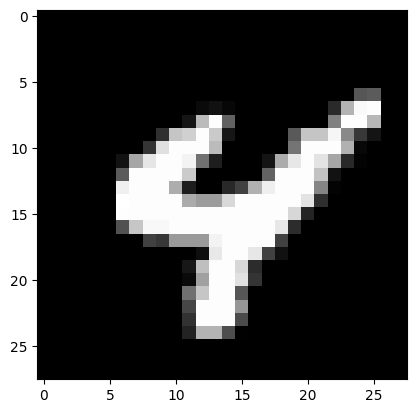

Prediction:  [9]
Label:  9


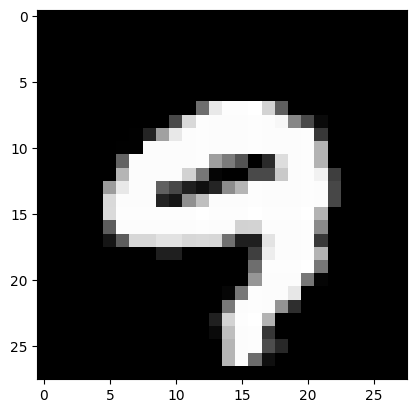

Prediction:  [0]
Label:  0


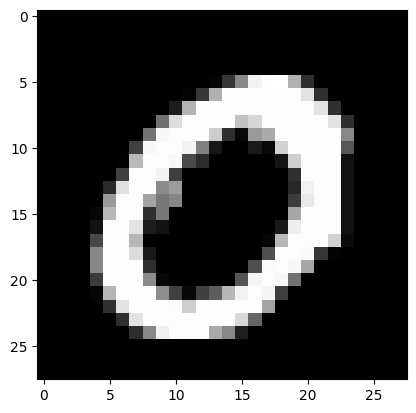

Prediction:  [0]
Label:  0


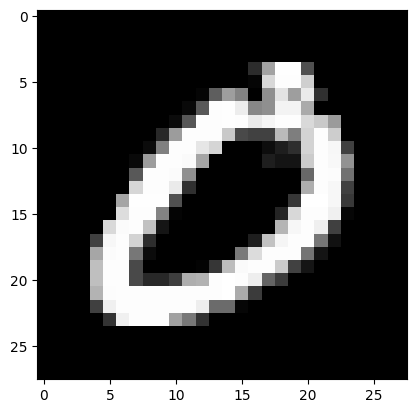

CPU times: user 455 ms, sys: 451 ms, total: 906 ms
Wall time: 352 ms


In [27]:
%%time
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

This Python code is testing the trained neural network's predictions on the first four samples from the training set. Here's a breakdown of what each line does:

1. `%%time`: This is a magic command in Jupyter Notebook that times the execution of the specific cell. It will output the time taken to run the cell once it completes.

2-5. `test_prediction(0, W1, b1, W2, b2)`, `test_prediction(1, W1, b1, W2, b2)`, `test_prediction(2, W1, b1, W2, b2)`, `test_prediction(3, W1, b1, W2, b2)`: These lines are calling the `test_prediction` function with the indices of the samples to test (0, 1, 2, and 3) and the trained weights and biases (`W1`, `b1`, `W2`, `b2`). The function will print the neural network's prediction and the true label for each sample, and display the corresponding image.

#### Finally, let's find the accuracy on the test set:

In [28]:
test_predictions = make_predictions(X_test, W1, b1, W2, b2)
acc = get_accuracy(test_predictions, y_test);
df = pd.DataFrame({'Label': y_test, 'Predicted': test_predictions})  # Create DataFrame 
df['Correct'] = df['Label'] == df['Predicted']  # Add 'Correct' column  
df

[0 0 1 3 2 6 9 3 9 9 9 1 9 5 7 0 3 8 4 3 5 6 9 3 1 6 6 8 4 7 7 4 8 6 6 7 9
 8 0 4 6 8 9 9 4 1 8 2 8 3 7 4 4 6 4 9 5 1 7 5 1 8 5 4 1 2 0 1 7 8 4 2 2 7
 8 5 6 1 2 3 1 3 7 4 9 4 1 8 4 1 1 3 1 1 1 1 5 1 6 1 1 0 0 0 3 3 6 7 5 6 3
 5 2 9 1 3 1 7 4 6 1 1 0 0 1 6 3 2 7 0 3 4 1 2 6 4 9 7 6 4 5 6 8 6 1 6 5 4
 9 4 0 3 9 9 9 5 1 1 6 1 8 1 8 7 6 2 3 8 0 7 8 3 7 5 7 7 3 9 9 1 7 8 6 0 2
 7 1 5 0 5 1 1 4 3 0 3 3 0 2 0 0 1 0 7 2 2 7 1 9 0 6 7 3 1 3 7 3 9 3 4 9 2
 2 6 1 2 3 0 7 0 3 1 6 8 4 3 5 5 7 1 4 6 5 7 7 0 6 6 9 8 7 4 5 7 4 8 9 8 5
 6 1 5 3 6 2 9 8 5 1 7 1 4 5 0 7 4 7 1 7 3 4 1 4 5 2 9 1 0 1 6 9 8 7 9 1 5
 5 0 0 3 1 5 9 7 3 0 5 9 6 6 3 0 9 6 9 8 9 9 0 8 6 2 2 2 4 4 0 2 7 0 4 6 1
 2 8 2 2 4 4 6 1 6 9 4 9 4 6 1 0 9 6 6 0 3 9 8 6 4 8 8 9 7 8 1 4 3 7 1 2 2
 5 0 9 4 2 1 3 1 6 0 6 4 8 4 3 5 1 1 1 0 7 7 2 5 0 3 9 1 1 1 7 8 8 9 6 7 8
 9 7 4 9 0 9 6 0 5 3 7 1 3 3 5 4 1 3 1 1 2 2 4 5 6 4 7 5 9 3 2 2 1 4 2 1 7
 6 4 8 8 8 2 2 6 7 6 1 9 8 4 3 8 8 9 0 0 1 5 6 3 8 9 1 3 4 8 3 7 8 0 4 8 1
 4 4 9 6 8 3 8 5 0 1 5 1 

,Label,Predicted,Correct
0,0,0,True
1,0,0,True
2,1,1,True
3,3,3,True
4,6,2,False
...,...,...,...
995,9,9,True
996,6,6,True
997,9,9,True
998,5,4,False


This Python code is making predictions on the test set using the trained neural network and then calculating the accuracy of these predictions. Here's a breakdown of what each line does:

1. `test_predictions = make_predictions(X_test, W1, b1, W2, b2)`: This line is calling the `make_predictions` function with the test set `X_test` and the trained weights and biases (`W1`, `b1`, `W2`, `b2`). The function performs forward propagation on `X_test` using the provided weights and biases, gets the predictions by calling the `get_predictions` function on the output of the last layer, and returns these predictions.

2. `get_accuracy(test_predictions, y_test)`: This line is calling the `get_accuracy` function with the predictions on the test set and the true labels `y_test`. The function calculates the accuracy as the proportion of predictions that exactly match the true labels, and prints this accuracy.


#### Cheeting, using `scikit-learn` for simplicity:

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(f'True label(rows 0,..., 9) vs. Predicted label (columns 0,..., 9) \n\n {confusion_matrix(y_test, test_predictions)}\n')
print(classification_report(y_test, test_predictions))

True label(rows 0,..., 9) vs. Predicted label (columns 0,..., 9) 

 [[ 87   0   1   0   0   2   1   1   0   0]
 [  0 132   2   2   0   2   0   0   5   0]
 [  1   2  68   1   1   0   5   1   1   1]
 [  1   2   6  75   0   7   1   3   4   0]
 [  0   1   0   0  78   0   1   2   2   9]
 [  1   1   0   5   2  72   2   2   4   1]
 [  1   2   1   0   6   0  98   0   2   0]
 [  1   1   3   0   0   0   0  89   0   7]
 [  0   1   2   3   0   5   0   1  64   5]
 [  2   1   1   1  12   2   0   7   4  80]]

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        92
           1       0.92      0.92      0.92       143
           2       0.81      0.84      0.82        81
           3       0.86      0.76      0.81        99
           4       0.79      0.84      0.81        93
           5       0.80      0.80      0.80        90
           6       0.91      0.89      0.90       110
           7       0.84      0.88      0.86       101
           8 

Still ~84% accuracy, so our model generalized from the training data pretty well.

## A **PyTorch** implementation with one hidden layers
Creating a similar neural network using PyTorch involves defining the model architecture, specifying the forward propagation steps, and setting up the training loop, which includes both forward and backward propagation. Let's dive into the PyTorch implementation:

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(784, 10)  # First layer (input to hidden)
        self.dense2 = nn.Linear(10, 10)   # Second layer (hidden to output)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.dense1(x))  # ReLU activation for hidden layer
        x = self.dense2(x)          # No activation yet for output layer
        return x

# Create the model
model = SimpleNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy dataset
# num_samples = 1000
# X_train = torch.rand(num_samples, 1, 28, 28)  # Simulating 28x28 grayscale images in MNIST
# y_train = torch.randint(0, 10, (num_samples,))  # Random labels for 10 classes

# Real dataset - in our case from the MNIST database, and convert it to proper tensors
X_train_reshape = X_train.T.reshape(-1, 1, 28, 28)  # Reshape to: num_samples, 1 batch size, flattened 28x28 grayscale images
X_train_torch = torch.from_numpy(X_train_reshape).float()
print(f'X_train_torch.shape = {X_train_torch.shape}')

y_train_torch = torch.from_numpy(y_train).long()
print(f'y_train_torch.shape = {y_train_torch.shape}')

# Create data loader
bs = 64 # Batch size
train_data = TensorDataset(X_train_torch, y_train_torch) 
train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()             # Zero the gradient buffers
        outputs = model(inputs)           # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward()                   # Backward pass
        optimizer.step()                  # Update weights

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.3f}")


# Print the model architecture
print(f'\nModel architecture: {model}')



X_train_torch.shape = torch.Size([41000, 1, 28, 28])
y_train_torch.shape = torch.Size([41000])
Epoch 1/10, Loss: 0.536
Epoch 2/10, Loss: 0.291
Epoch 3/10, Loss: 0.313
Epoch 4/10, Loss: 0.396
Epoch 5/10, Loss: 0.201
Epoch 6/10, Loss: 0.171
Epoch 7/10, Loss: 0.136
Epoch 8/10, Loss: 0.382
Epoch 9/10, Loss: 0.361
Epoch 10/10, Loss: 0.170

Model architecture: SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=784, out_features=10, bias=True)
  (dense2): Linear(in_features=10, out_features=10, bias=True)
)


This Python script is implementing a simple neural network for a classification task using PyTorch. Here's a breakdown of what each part does:

1. **Import necessary libraries**: The script starts by importing the necessary PyTorch modules.

2. **Define the neural network architecture**: A simple neural network is defined using the `nn.Module` class from PyTorch. This network has an input layer (`self.dense1`), a hidden layer with ReLU activation function (`F.relu(self.dense1(x))`), and an output layer (`self.dense2`).

3. **Create the model**: An instance of the `SimpleNN` class is created. This instance, `model`, is the neural network that will be trained.

4. **Define the loss function and optimizer**: The script uses cross-entropy loss (`nn.CrossEntropyLoss()`) as the loss function and the Adam optimizer (`optim.Adam()`) for training the neural network.

5. **Prepare the data**: The script reshapes the training data (`X_train`) to match the input shape expected by the neural network and converts it to a PyTorch tensor. It also converts the training labels (`y_train`) to a PyTorch tensor. These tensors are then used to create a `TensorDataset`, which is a dataset wrapping tensors. A `DataLoader` is created for the `TensorDataset` to handle batching of the data.

6. **Train the model**: The script then enters a training loop. For each epoch, it iterates over the `DataLoader`, performing a forward pass, calculating the loss, performing a backward pass, and updating the weights of the neural network.

7. **Print the model architecture**: Finally, the script prints the architecture of the model.


###  Make predictions with the trained one-hidden layer PyTorch model

To make predictions on an unseen test dataset and report performance metrics, you'll need to:

1. Load the unseen dataset (i.e. the X_test and y_test arrays). They are reprocessed in the same way as the training data.
3. Pass the data through the model to get predictions.
4. Compare the predictions with the true labels to calculate performance metrics.

Here's how you can do it:

In [31]:
# Real unseen (_dev) dataset - in our case from the MNIST database, and convert it to proper tensors
X_test_reshape = X_test.T.reshape(-1, 1, 28, 28)  # Reshape to: num_samples, 1 batch size, flattened 28x28 grayscale images
X_test_torch = torch.from_numpy(X_test_reshape).float()
print(f'X_test_torch.shape = {X_test_torch.shape}')

y_test_torch = torch.from_numpy(y_test).long()
print(f'y_test_torch.shape = {y_test_torch.shape}')

X_test_torch.shape = torch.Size([1000, 1, 28, 28])
y_test_torch.shape = torch.Size([1000])


This Python code is preparing the unseen test dataset for evaluation with a PyTorch model. Here's a breakdown of what each line does:

1. `X_test_reshape = X_test.T.reshape(-1, 1, 28, 28)`: This line reshapes the test data `X_test` into a format that can be used with the PyTorch model. The `-1` in the reshape function means that this dimension will be determined based on the size of the other dimensions, so the resulting shape will be `(num_samples, 1, 28, 28)`. This is the shape expected by the PyTorch model: `num_samples` samples, each with 1 channel (because the images are grayscale), and each image is 28x28 pixels.

2. `X_test_torch = torch.from_numpy(X_test_reshape).float()`: This line converts the reshaped test data into a PyTorch tensor of type float.

3. `print(f'X_test_torch.shape = {X_test_torch.shape}')`: This line prints the shape of the test data tensor. This is useful for debugging and ensuring that the data is in the correct format.

4. `y_test_torch = torch.from_numpy(y_dev).long()`: This line converts the test labels `y_test` into a PyTorch tensor of type long. The PyTorch model expects the labels to be in this format.

5. `print(f'y_test_torch.shape = {y_test_torch.shape}')`: This line prints the shape of the test labels tensor. This is useful for debugging and ensuring that the labels are in the correct format.


In [32]:
%%time 

from sklearn.metrics import classification_report
import torch

# Load the unseen dataset
#test_data = pd.read_csv('data/test.csv')

# Preprocess the data
#X_test = test_data.drop('label', axis=1).values / 255
#y_test = test_data['label'].values
#X_test_torch = torch.from_numpy(X_test).float()
#y_test_torch = torch.from_numpy(y_test).long()

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Temporarily turn off gradient descent
    outputs = model(X_test_torch)
    _, predicted = torch.max(outputs, 1)

# Calculate performance metrics
print(classification_report(y_test_torch, predicted))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95        92
           1       0.95      0.94      0.95       143
           2       0.91      0.86      0.89        81
           3       0.93      0.83      0.88        99
           4       0.85      0.95      0.90        93
           5       0.89      0.89      0.89        90
           6       0.93      0.94      0.93       110
           7       0.91      0.92      0.92       101
           8       0.86      0.95      0.90        81
           9       0.92      0.88      0.90       110

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

CPU times: user 24.7 ms, sys: 39.6 ms, total: 64.4 ms
Wall time: 10.8 ms




This script uses the `classification_report` function from `sklearn.metrics` to calculate and print several performance metrics, including precision, recall, f1-score, and support for each class, as well as the overall accuracy of the model.

Please note that this script assumes that your dev dataset is in the same format as your training dataset and that it's located at 'data/dev.csv'. If this is not the case, you'll need to adjust the script accordingly.



In this example, `model` is an instance of the `Net` class, which is a simple feed-forward neural network with one hidden layer. The `forward` method defines the forward pass of the network.

In your provided code, `model.eval()` is used to set the model to evaluation mode. This turns off features like dropout and batch normalization that are used during training but not during evaluation.

Then, `outputs = model(X_test_torch)` is used to make predictions on the test data. The model's forward pass is called with the test data as input, and it returns the raw, unnormalized scores (also known as logits) for each class.

Finally, `_, predicted = torch.max(outputs, 1)` is used to get the predicted class indices. `torch.max()` returns the maximum value of all elements in the `outputs` tensor along the dimension 1 (which represents the class dimension), and its corresponding indices. The underscore `_` is a conventional variable used to store the maximum values, which are not needed in this case. The `predicted` tensor contains the predicted class indices.

## A PyTorch implementation with two hidden layers

Creating a PyTorch model for MNIST classification with the initially specified architecture (2 hiddel layers) involves several steps. The MNIST dataset consists of 28x28 pixel grayscale images of handwritten digits (0-9), which we flatten into a 784-dimensional input vector for feeding into a neural network. The network will have two hidden layers and a final output layer that uses one-hot encoding for the 10 possible classes (digits 0-9). Here's a step-by-step guide to the PyTorch code for this task:

Cf. multiple hidden layers in:

<img src="assets/Waldrop-multiple-hidden-layers.png" width=720>

## Some theory

#### - Back-propagation (of errors) in a multi-layer perceptron with multiple hidden layers

To derive the back-propagation algorithm for a feed-forward neural network (NN) with two hidden layers, particularly for the MNIST dataset, we will first outline the architecture of the network and the functions involved. The network consists of 784 input nodes (corresponding to the 28x28 pixels of the MNIST images), two hidden layers with an arbitrary number of nodes $ h_1 $ and $ h_2 $ respectively, and 10 output nodes corresponding to the 10 digit classes. The activation functions used are ReLU for the hidden layers and softmax for the output layer.

#### Activation functions:
Definition of **ReLU** and **softmax** functions:

$ \text{ReLU}(z) = \max(0, z) $, where $z$ is real number, and $ \text{softmax}(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{10} e^{z_j}} $, where $\mathbf{z}$ is a vector of size 10. The range of softmax($\mathbf{z}$) is (0,1), and the entire output vector sums up to 1, behaving like a probability distribution over 10 classes.

### Network Architecture

1. **Input Layer**: 784 nodes ($ x_i, i = 1 \text{ to } 784 $)
2. **First Hidden Layer**: $ h_1 $ nodes with ReLU activation ($ z^{[1]} $ and $ a^{[1]} $)
3. **Second Hidden Layer**: $ h_2 $ nodes with ReLU activation ($ z^{[2]} $ and $ a^{[2]} $)
4. **Output Layer**: 10 nodes with Softmax activation ($ z^{[3]} $ and $ a^{[3]} $)

### Forward Propagation

1. **First Hidden Layer**:

    $ z^{[1]} = W^{[1]}x + b^{[1]} \\$

    $ a^{[1]} = \text{ReLU}(z^{[1]}) $

2. **Second Hidden Layer**:

    $ z^{[2]} = W^{[2]}a^{[1]} + b^{[2]} \\$

    $ a^{[2]} = \text{ReLU}(z^{[2]}) $

3. **Output Layer**:

    $ z^{[3]} = W^{[3]}a^{[2]} + b^{[3]} \\$
    
    $ a^{[3]} = \text{softmax}(z^{[3]}) $

### Back-Propagation

The goal of back-propagation is to compute the gradient of the loss function with respect to each weight and bias in the network.<br><br>

1. **Loss Function**: Cross-entropy loss is typically used for classification tasks.<br>

    $ L(y, \hat{y}) = - \sum_{i=1}^{10} y_i \log(\hat{y}_i) \,$, where $ y $ is the true label and $ \hat{y} = a^{[3]} $ is the predicted output. The loss function is a scalar value. <br><br><br>

2. **Output Layer Gradients**:

    $ \frac{\partial L}{\partial z^{[3]}} = a^{[3]} - y \\ \\$

    $ \frac{\partial L}{\partial W^{[3]}} = \frac{\partial L}{\partial z^{[3]}} a^{[2]T} \\ \\ $
   
    $ \frac{\partial L}{\partial b^{[3]}} = \frac{\partial L}{\partial z^{[3]}} \\$ <br><br>

3. **Second Hidden Layer Gradients**:

    $ \frac{\partial L}{\partial z^{[2]}} = (W^{[3]T} \frac{\partial L}{\partial z^{[3]}}) * g'(z^{[2]}) $, 
    where $ * $ denotes element-wise multiplication and $ g'(z^{[2]}) $ is the derivative of the ReLU function.
    
    $ \frac{\partial L}{\partial W^{[2]}} = \frac{\partial L}{\partial z^{[2]}} a^{[1]T} \\ \\$
    
    $ \frac{\partial L}{\partial b^{[2]}} = \frac{\partial L}{\partial z^{[2]}} $
    <br><br><br>

4. **First Hidden Layer Gradients**:

    $ \frac{\partial L}{\partial z^{[1]}} = (W^{[2]T} \frac{\partial L}{\partial z^{[2]}}) * g'(z^{[1]}) \\ \\$
    
    $ \frac{\partial L}{\partial W^{[1]}} = \frac{\partial L}{\partial z^{[1]}} x^T \\ \\$

    $ \frac{\partial L}{\partial b^{[1]}} = \frac{\partial L}{\partial z^{[1]}} \\$

### Update Rules

The weights and biases are updated using gradient descent: <br>


**Weights**:
    $ W^{[l]} := W^{[l]} - \alpha \frac{\partial L}{\partial W^{[l]}}  \\ \\ $   
**Biases**:  $ b^{[l]} := b^{[l]} - \alpha \frac{\partial L}{\partial b^{[l]}} \\ $

where $ \alpha $ is the learning rate.  <br><br>



#### Specify variables and shapes in forward propagation and backward propagatio

Specifying the shapes of variables in both forward and backward propagation helps to clarify the implementation of the neural network.

### Forward Propagation

- **Input Layer**: 
  - Input $ X $: Shape $(784, m)$ where $ m $ is the number of examples.

- **First Hidden Layer**:
  - Weights $ W^{[1]} $: Shape $(h_1, 784)$
  - Bias $ b^{[1]} $: Shape $(h_1, 1)$
  - Linear combination $ z^{[1]} = W^{[1]}X + b^{[1]} $: Shape $(h_1, m)$
  - Activation $ a^{[1]} = \text{ReLU}(z^{[1]}) $: Shape $(h_1, m)$

- **Second Hidden Layer**:
  - Weights $ W^{[2]} $: Shape $(h_2, h_1)$
  - Bias $ b^{[2]} $: Shape $(h_2, 1)$
  - Linear combination $ z^{[2]} = W^{[2]}a^{[1]} + b^{[2]} $: Shape $(h_2, m)$
  - Activation $ a^{[2]} = \text{ReLU}(z^{[2]}) $: Shape $(h_2, m)$

- **Output Layer**:
  - Weights $ W^{[3]} $: Shape $(10, h_2)$
  - Bias $ b^{[3]} $: Shape $(10, 1)$
  - Linear combination $ z^{[3]} = W^{[3]}a^{[2]} + b^{[3]} $: Shape $(10, m)$
  - Activation $ a^{[3]} = \text{softmax}(z^{[3]}) $: Shape $(10, m)$

### Backward Propagation

- **Output Layer**:
  - Gradient of loss w.r.t. output $ \frac{\partial L}{\partial z^{[3]}} $: Shape $(10, m)$
  - Gradient of loss w.r.t. weights $ \frac{\partial L}{\partial W^{[3]}} $: Shape $(10, h_2)$
  - Gradient of loss w.r.t. biases $ \frac{\partial L}{\partial b^{[3]}} $: Shape $(10, 1)$

- **Second Hidden Layer**:
  - Gradient of loss w.r.t. pre-activation $ \frac{\partial L}{\partial z^{[2]}} $: Shape $(h_2, m)$
  - Gradient of loss w.r.t. weights $ \frac{\partial L}{\partial W^{[2]}} $: Shape $(h_2, h_1)$
  - Gradient of loss w.r.t. biases $ \frac{\partial L}{\partial b^{[2]}} $: Shape $(h_2, 1)$

- **First Hidden Layer**:
  - Gradient of loss w.r.t. pre-activation $ \frac{\partial L}{\partial z^{[1]}} $: Shape $(h_1, m)$
  - Gradient of loss w.r.t. weights $ \frac{\partial L}{\partial W^{[1]}} $: Shape $(h_1, 784)$
  - Gradient of loss w.r.t. biases $ \frac{\partial L}{\partial b^{[1]}} $: Shape $(h_1, 1)$

### Update Rules

- The weights and biases are updated by subtracting the product of the learning rate and the respective gradients:
  - $ W^{[l]} := W^{[l]} - \alpha \frac{\partial L}{\partial W^{[l]}} $
  - $ b^{[l]} := b^{[l]} - \alpha \frac{\partial L}{\partial b^{[l]}} $

This outline should provide a clear understanding of the shapes and flow of data through a neural network designed for the MNIST dataset. Remember, the actual values for $ h_1 $ and $ h_2 $ (the number of nodes in the hidden layers) are design choices that depend on the specific implementation and experimentation.

### Specifying initial values:

To specify the initial values of the variables in a neural network designed for the MNIST dataset, we typically follow certain conventions and best practices. These initial values are crucial as they can significantly impact the convergence and performance of the network.

#### Initial Values of Variables

- **Input Layer**: 
  - Input $ X $: Contains the MNIST images. Each image is flattened to a 784-dimensional vector (since MNIST images are 28x28 pixels).

- **First Hidden Layer**:
  - Weights $ W^{[1]} $: Initialized randomly to break symmetry. Often initialized from a normal distribution with mean 0 and a small standard deviation (e.g., 0.01).
  - Bias $ b^{[1]} $: Typically initialized to zero. Shape $(h_1, 1)$, where $ h_1 $ is the number of nodes in the first hidden layer.

- **Second Hidden Layer**:
  - Weights $ W^{[2]} $: Also initialized randomly, similar to $ W^{[1]} $.
  - Bias $ b^{[2]} $: Initialized to zero. Shape $(h_2, 1)$, where $ h_2 $ is the number of nodes in the second hidden layer.

- **Output Layer**:
  - Weights $ W^{[3]} $: Randomly initialized.
  - Bias $ b^{[3]} $: Initialized to zero. Shape $(10, 1)$ since there are 10 output classes.

#### Remarks on Initialization

- **Random Initialization of Weights**: This is crucial to avoid symmetry during training. If all weights are initialized to the same value, all neurons in a layer will learn the same features, which is not desirable.
  
- **Zero Initialization of Biases**: Initializing biases to zero is a common practice. Since weights are randomly initialized, this still leads to asymmetry in the learning process.

- **Magnitude of Weight Initialization**: The scale of initial weights should be neither too large nor too small. Large weights can cause the activation function to saturate, while too small weights can slow down the learning process. He or Xavier initialization methods are often used to maintain a balance.

- **Shape of Weights and Biases**: It's important to ensure the dimensions of weights and biases match the architecture of the network. For example, if the first hidden layer has $ h_1 $ nodes, the shape of $ W^{[1]} $ will be $(h_1, 784)$ and that of $ b^{[1]} $ will be $(h_1, 1)$.

- **Specific Values for $ h_1 $ and $ h_2 $**: The number of nodes in the hidden layers $ h_1 $ and $ h_2 $ are hyperparameters that you need to decide based on experimentation and the requirements of your task. A common practice is to start with a smaller number of nodes and increase them based on the performance of the network.

In summary, initializing the neural network correctly is a critical step in preparing it for effective training on datasets like MNIST. The choices made here can have significant implications for the learning dynamics and the final performance of the model.

**This provides a comprehensive overview of the back-propagation process for a neural network with two hidden layers, tailored to the MNIST dataset. It's crucial to implement these equations accurately in your code to train the neural network effectively.**

### A PyTorch implementation of a two-hidden layer NN

We create a two-hidden layer PyTorch neural network for the MNIST dataset, train it, and then evaluate its performance by displaying metrics, the confusion matrix, and misclassified instances, following these steps:

- Define the Neural Network Class
- Load and Preprocess the MNIST Data
- Instantiate the Model, Loss Function, and Optimizer
- Train the Model
- Test the Model and Collect Data for Evaluation
- Evaluate the Performance

### Import necessary libraries

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### 1. Define the Neural Network
Here's a class definition for the neural network. It includes an input layer, two hidden layers, and an output layer. The `forward` method defines the sequence of operations for forward propagation.

In [34]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 128) # First hidden layer with 128 neurons
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer with 64 neurons
        self.fc3 = nn.Linear(64, 10)   # Output layer with 10 neurons (one for each class)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation function for first hidden layer
        x = F.relu(self.fc2(x))  # Activation function for second hidden layer
        x = self.fc3(x)          # No activation needed in the output layer
        return x

### 2. Load and Preprocess the MNIST Data

In [35]:
# MNIST Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


### 3. Instantiate the Model, Loss Function, and Optimizer

In [36]:
model = MNISTClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### 4. Train the Model
Define a function to train the model.

In [37]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()


### 5. Test the Model and Collect Data for Evaluation
Modify the test function to collect misclassified instances and compute the confusion matrix.

In [38]:
def test_and_collect_misclassified(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix_data = np.zeros((10, 10), dtype=int)
    misclassified_images = []
    misclassified_true_labels = []
    misclassified_pred_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Confusion matrix and misclassified images
            for t, p in zip(target.view_as(pred), pred):
                confusion_matrix_data[t.item(), p.item()] += 1

            misclassified = (pred != target.view_as(pred)).squeeze()
            misclassified_images.extend(data[misclassified].to(device)) # .cpu())
            misclassified_true_labels.extend(target[misclassified].to(device)) # .cpu())
            misclassified_pred_labels.extend(pred[misclassified].to(device)) # .cpu())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return confusion_matrix_data, misclassified_images, misclassified_true_labels, misclassified_pred_labels, test_loss, accuracy

#### 5a. Plot confusion matrix  

In [39]:
def plot_confusion_matrix(cm):   # seaborn version
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, annot_kws={"size": 16})
    plt.title('Confusion Matrix')
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

def plot_confusion_matrix_plt(cm):  # matplotlib version
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_title('Confusion Matrix')

    # Loop over data dimensions and create text annotations
    for i in range(10):
        for j in range(10):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2. else "black")
    
    plt.show()

#### 5b. Plot misclassified instances   (5 x 5 grid)

In [40]:
def plot_misclassified_images(images, true_labels, pred_labels):
    plt.figure(figsize=(10, 10))
    for i, (img, true_label, pred_label) in enumerate(zip(images, true_labels, pred_labels)):
        plt.subplot(5, 5, i+1)
        plt.imshow(img.cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title(f'True: {true_label.item()}, Pred: {pred_label.item()}', fontsize=8)
        plt.axis('off')
    plt.show()

#### 5c. View an image in more detail  (28 x28 annotated pixel-grid)

In [41]:
def view_an_image_in_more_detail(inp_img, title=None):

    img = np.squeeze(inp_img)
    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    if title:
        ax.set_title(title, fontsize=20)
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

### 6. Evaluate the Performance
After training, evaluate the model and display the results

In [42]:
%%time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
n_epochs = 10
for epoch in range(0, n_epochs):  # Adjust the number of epochs as needed
    print(f'Epoch {epoch+1}/{n_epochs}\n-------------------------------')    
    train(model, device, train_loader, optimizer, epoch)

# Evaluation
confusion_data, misclassified_imgs, true_lbls, pred_lbls, test_loss, accuracy = test_and_collect_misclassified(model, device, test_loader)

# Display metrics
print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch 1/10
-------------------------------
Epoch 2/10
-------------------------------
Epoch 3/10
-------------------------------
Epoch 4/10
-------------------------------
Epoch 5/10
-------------------------------
Epoch 6/10
-------------------------------
Epoch 7/10
-------------------------------
Epoch 8/10
-------------------------------
Epoch 9/10
-------------------------------
Epoch 10/10
-------------------------------
Test Loss: 0.0001, Accuracy: 97.73%
CPU times: user 53.7 s, sys: 283 ms, total: 54 s
Wall time: 52.7 s


In [43]:
%%time 

# Load the unseen dataset
#test_data = pd.read_csv('data/test.csv')

# Preprocess the data
#X_test = test_data.drop('label', axis=1).values / 255
#y_test = test_data['label'].values
#X_test_torch = torch.from_numpy(X_test).float()
#y_test_torch = torch.from_numpy(y_test).long()

X_test_torch = []
y_test_torch = []

for data, label in test_dataset:
    X_test_torch.append(data)
    y_test_torch.append(label)

# Convert lists to tensors and move to device (cpu or cuda:0)
X_test_torch = torch.stack(X_test_torch).to(device)
y_test_torch = torch.tensor(y_test_torch).to(device)

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Temporarily turn off gradient descent
    outputs = model(X_test_torch)
    _, predicted = torch.max(outputs, 1)

# Move tensors back to CPU for further processing
predicted = predicted.to('cpu')
y_test_torch = y_test_torch.to('cpu')

# Calculate performance metrics
print(classification_report(y_test_torch, predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

CPU times: user 628 ms, sys: 23.9 ms, total: 652 ms
Wall time: 655 ms


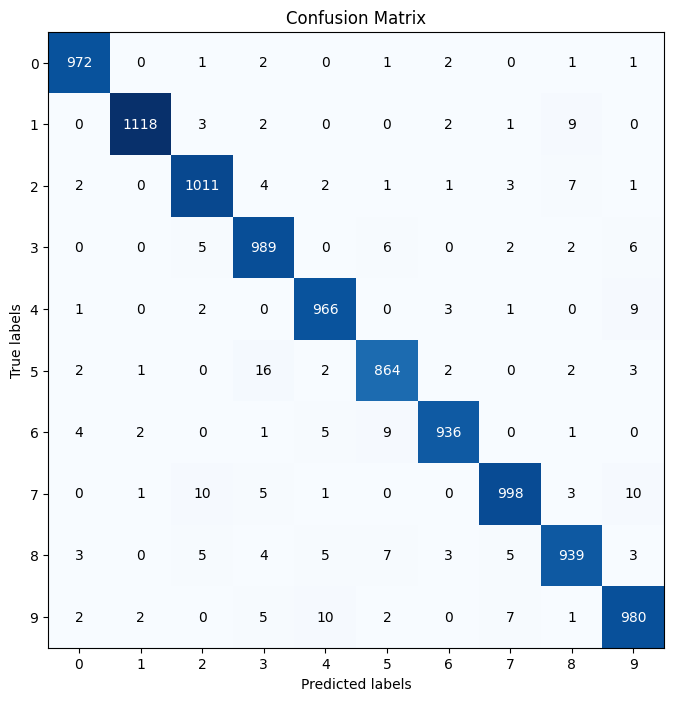

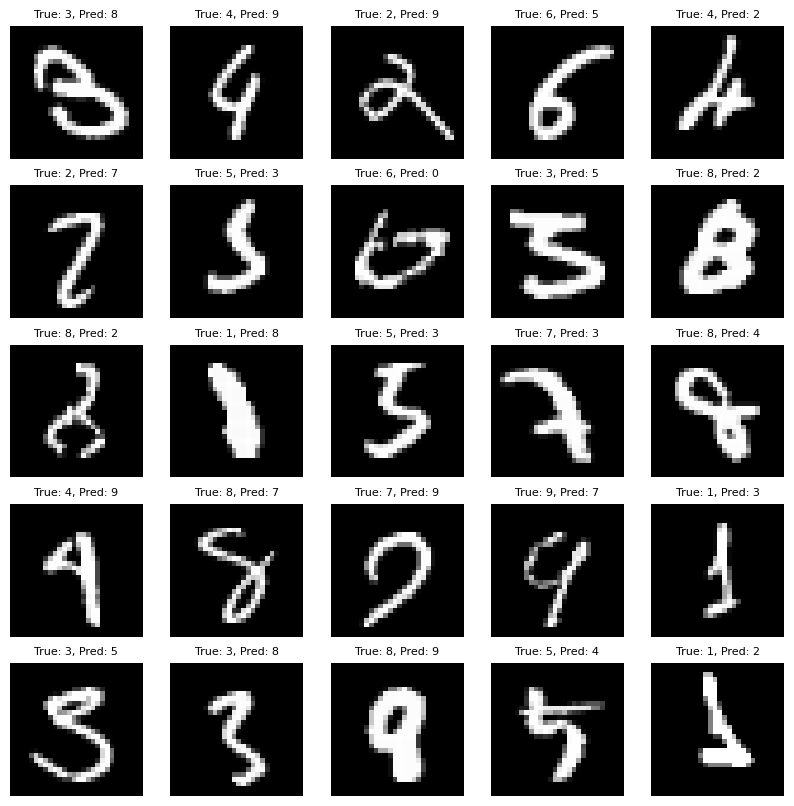

In [44]:
# Display confusion matrix and misclassified images
plot_confusion_matrix_plt(confusion_data)
# plot_confusion_matrix(confusion_data)
plot_misclassified_images(misclassified_imgs[:25], true_lbls[:25], pred_lbls[:25])

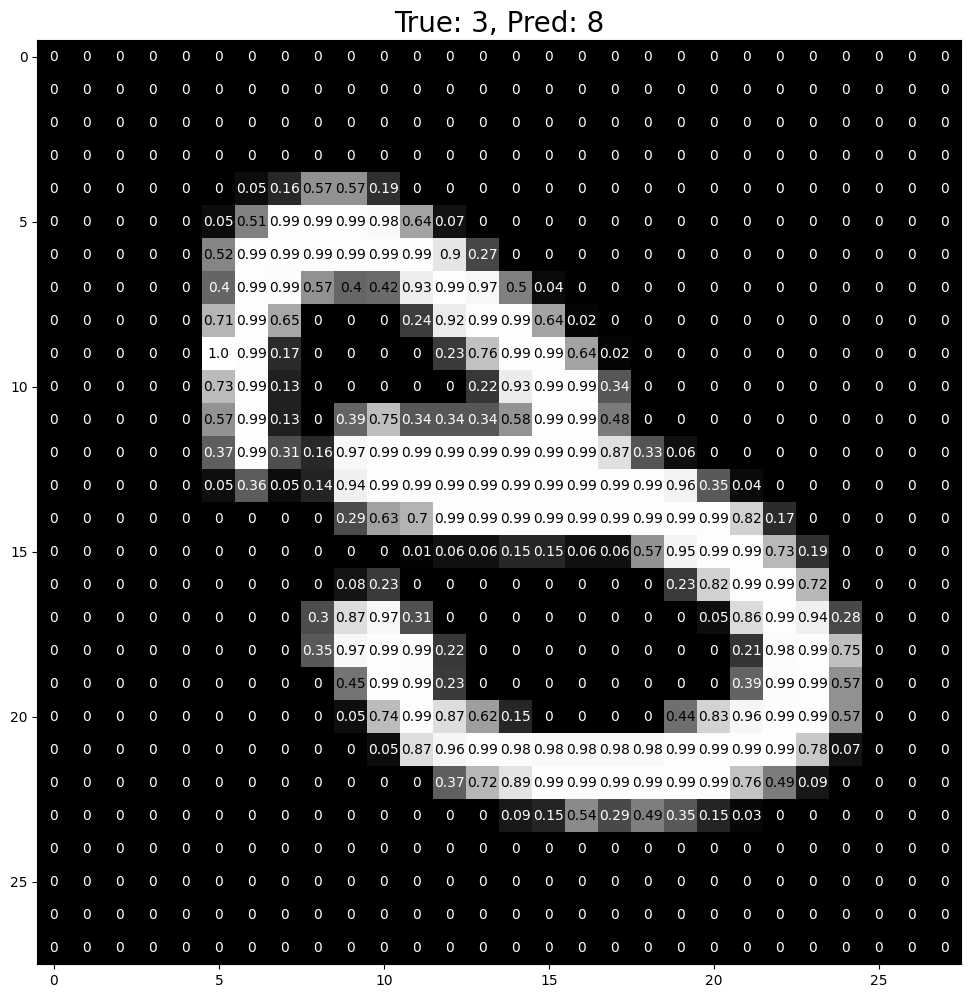

In [45]:
inp_img = misclassified_imgs[0].cpu().numpy().reshape(28, 28)
txt = 'True: {0}, Pred: {1}'.format(true_lbls[0].item(), pred_lbls[0].item())
view_an_image_in_more_detail(inp_img, txt)

This code provides a basic structure for an MNIST classifier using PyTorch. 
It will also provide a visual understanding of your model's performance, showing where it gets confused and what kinds of mistakes it makes. This is particularly useful for fine-tuning and improving your model. You can modify the number of neurons in the hidden layers, the number of epochs, or other parameters to experiment with the network's performance.